[*********************100%%**********************]  1 of 1 completed


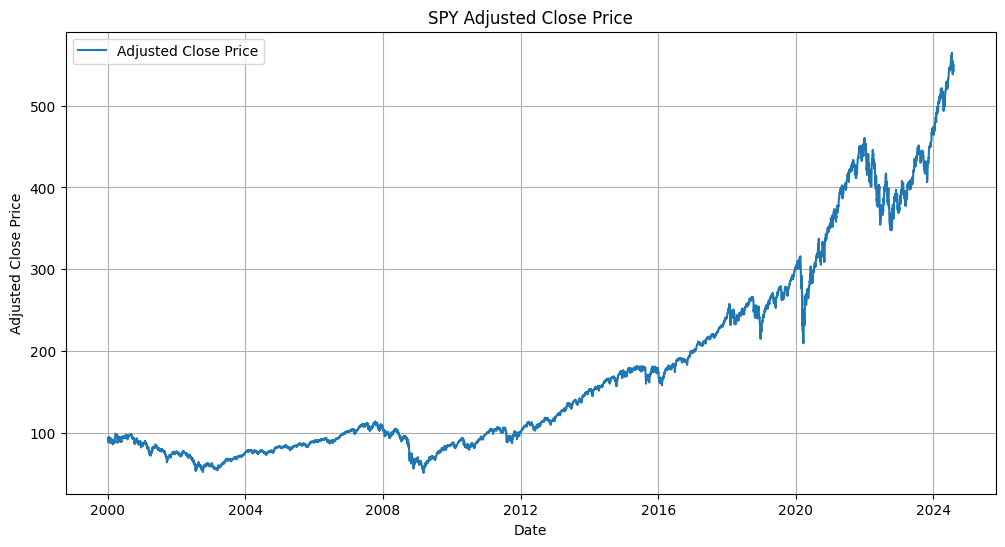

Data has been downloaded, filled, plotted


In [22]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import numpy as np

# Define the ticker symbol for SPY ETF
ticker_symbol = 'SPY'

# Get today's date
end_date = datetime.today().strftime('%Y-%m-%d')

# Download all available historical data for SPY
df = yf.download(ticker_symbol, start="2000-01-01", end=end_date)

# Plot the Adjusted Close prices
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Adj Close'], label='Adjusted Close Price')
plt.title('SPY Adjusted Close Price')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.legend()
plt.grid(True)
plt.show()

print("Data has been downloaded, filled, plotted")


In [23]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2000-01-03,148.25000,148.25000,143.875000,145.4375,93.290169,8164300
2000-01-04,143.53125,144.06250,139.640625,139.7500,89.641922,8089800
2000-01-05,139.93750,141.53125,137.250000,140.0000,89.802277,12177900
2000-01-06,139.62500,141.50000,137.750000,137.7500,88.359123,6227200
2000-01-07,140.31250,145.75000,140.062500,145.7500,93.490639,8066500


In [24]:
# make features
df['FastSMA']  = df['Close'].rolling(16).mean()
df['SlowSMA']  = df['Close'].rolling(33).mean()
feats = ['FastSMA', 'SlowSMA']

In [25]:
df['LogReturn'] = np.log(df['Close']).diff()

In [26]:
# split into train and test
Ntest = 1000
train_data = df.iloc[:-Ntest].copy()
test_data = df.iloc[-Ntest:].copy()

In [27]:
class Env:
  def __init__(self, df):
    self.df = df
    self.n = len(df)
    self.current_idx = 0
    self.action_space = [0, 1, 2] # BUY, SELL, HOLD
    self.invested = 0

    self.states = self.df[feats].to_numpy()
    self.rewards = self.df['LogReturn'].to_numpy()
    self.total_buy_and_hold = 0

  def reset(self):
    self.current_idx = 0
    self.total_buy_and_hold = 0
    self.invested = 0
    return self.states[self.current_idx]

  def step(self, action):
    # need to return (next_state, reward, done)
    self.current_idx += 1
    if self.current_idx >= self.n:
      raise Exception("Episode already done")

    if action == 0: # BUY
      self.invested = 1
    elif action == 1: # SELL
      self.invested = 0
    
    # compute reward
    if self.invested:
      reward = self.rewards[self.current_idx]
    else:
      reward = 0

    # state transition
    next_state = self.states[self.current_idx]

    # baseline
    self.total_buy_and_hold += self.rewards[self.current_idx]

    # done flag
    done = (self.current_idx == self.n - 1)
    return next_state, reward, done

In [28]:
class Agent:
  def __init__(self):
    self.is_invested = False

  def act(self, state):
    assert(len(state) == 2)
    # (fast, slow)

    if state[0] > state[1] and not self.is_invested:
      self.is_invested = True
      return 0 # Buy

    if state[0] < state[1] and self.is_invested:
      self.is_invested = False
      return 1 # sell

    return 2 # Do nothing

In [29]:
def play_one_episode(agent, env):
  state = env.reset()
  done = False
  total_reward = 0
  agent.is_invested = False

  while not done:
    action = agent.act(state)
    next_state, reward, done = env.step(action)
    total_reward += reward
    state = next_state

  return total_reward

In [30]:
train_env = Env(train_data)
test_env = Env(test_data)

In [31]:
agent = Agent()

In [32]:
train_reward = play_one_episode(agent, train_env)

In [33]:
test_reward = play_one_episode(agent, test_env)

In [34]:
train_reward, train_env.total_buy_and_hold

(np.float64(0.6699540651108533), np.float64(0.8360841592275357))

In [35]:
train_reward, train_env.total_buy_and_hold

(np.float64(0.6699540651108533), np.float64(0.8360841592275357))